In [ ]:
import os
from tqdm import tqdm
import cv2

# Créer le répertoire de destination s'il n'existe pasimport os
from tqdm import tqdm
import cv2

# Définir les chemins
dataset_path = '/kaggle/input/ffhq-face-data-set/thumbnails128x128'
output_dir = "./128*128"
limit=6000

def process_images_directly(dataset_path, output_dir, limit):
    # Créer le répertoire de destination s'il n'existe pas
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    images = []
    # Charger les fichiers depuis le répertoire source
    for path, subdirs, files in os.walk(dataset_path):
        for name in files:
            images.append(os.path.join(path, name))
            if len(images) >= limit:
                break
        if len(images) >= limit:
            break

    # Créer des images en niveaux de gris sans redimensionnement
    for img_path in tqdm(images, desc="Traitement des images", unit="image"):
        inp = cv2.imread(img_path, 0)  # Lire l'image en niveaux de gris
        output_path = os.path.join(output_dir, os.path.basename(img_path))  # Chemin de sortie
        cv2.imwrite(output_path, inp)  # Enregistrer l'image en niveaux de gris


if __name__ == "__main__":
    process_images_directly(dataset_path, output_dir, limit)



Traitement des images: 100%|██████████| 6000/6000 [00:15<00:00, 382.58image/s]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [ ]:
def load_data(img_dir):
    data = []
    image_paths = [os.path.join(img_dir,w) for w in os.listdir(img_dir) if w.endswith(".png")]
    for image_path in image_paths:
        data.append(cv2.imread(image_path, 0))
    return np.array(data)

In [ ]:
data = load_data('/kaggle/working/128*128')
print(data[1:])

[[[187 187 188 ... 185 186 183]
  [187 187 189 ... 185 182 181]
  [188 189 188 ... 183 180 183]
  ...
  [178 182 187 ... 181 182 183]
  [178 177 180 ... 189 192 194]
  [178 169 165 ... 206 210 215]]

 [[ 40  34  37 ...  74  79  70]
  [ 36  32  32 ...  82  76  80]
  [ 34  31  34 ...  55  74  73]
  ...
  [ 17  16  17 ... 111 114  47]
  [ 16  16  16 ...  49 123  99]
  [ 17  15  16 ...  59 103 107]]

 [[238 238 235 ... 182 175 166]
  [237 237 235 ... 186 174 164]
  [233 236 231 ... 188 176 162]
  ...
  [207 163 117 ... 160 170 192]
  [ 96  75  99 ... 169 159 179]
  [ 72  80  79 ... 177 169 168]]

 ...

 [[ 11  11  11 ...   6   7   6]
  [ 11  10  11 ...   8   8   7]
  [ 11  11  12 ...   9   9   8]
  ...
  [160 153  72 ... 229 227 223]
  [178 153 107 ... 228 223 223]
  [191 161 123 ... 229 227 228]]

 [[ 41  42  43 ...  94 102 113]
  [ 44  46  45 ...  94 115 113]
  [ 45  46  46 ...  97 123  97]
  ...
  [122  85  80 ...  56  59  61]
  [132 110  83 ...  57  58  61]
  [134 127 100 ...  56  57  

In [ ]:
# test train split
split_rat = int(0.9*len(data))
data = data.astype('float32') / 255.
x_train = data[:split_rat]
x_test = data[split_rat:]
print (x_train.shape)
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
print(type(x_train[0]))
print (x_train.shape)
print (x_test.shape)


(5400, 128, 128)
<class 'numpy.ndarray'>
(5400, 128, 128, 1)
(600, 128, 128, 1)


In [ ]:
class ConvAutoEncoder(Model):
    def __init__(self):
        super(ConvAutoEncoder, self).__init__()
        self.encoder = tf.keras.Sequential([
        layers.Input(shape=(128, 128, 1)),
        layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2),
        layers.Conv2D(4, (3,3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(4, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = ConvAutoEncoder()

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())


In [ ]:
autoencoder.encoder.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 4)      │           292 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 372 (1.45 KB)

 Trainable params: 372 (1.45 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_transpose_4              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ ?                      │   0 (unbuilt) │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 32s 176ms/step - loss: 0.0501 - val_loss: 0.0073
Epoch 2/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 176ms/step - loss: 0.0057 - val_loss: 0.0038
Epoch 3/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 5/5
169/169 ━━━━━━━━━━━━━━━━━━━━ 30s 175ms/step - loss: 0.0024 - val_loss: 0.0022


In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


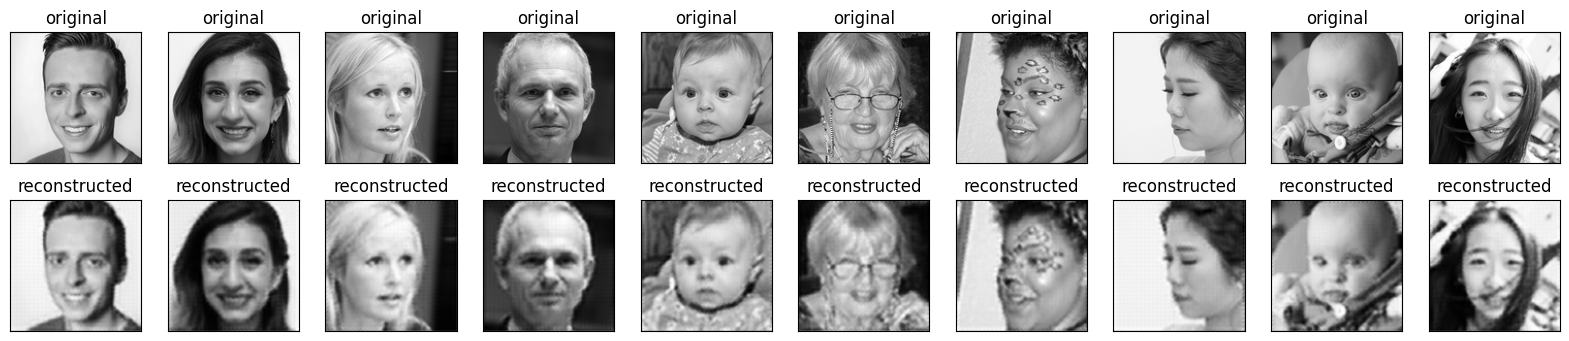

In [ ]:
n = 10

plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(tf.squeeze(x_test[i]))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
# Calculer les reconstructions pour les données de test
reconstructions = autoencoder.predict(x_test)

# Calculer la MSE ou la MAE entre les reconstructions et les données originales
mse = np.mean(np.square(reconstructions- x_test))
mae = np.mean(np.abs(reconstructions - x_test))

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step
Mean Squared Error (MSE): 0.0013512659
Mean Absolute Error (MAE): 0.03098352
